In [1]:
import numpy as np
import uproot 
import scipy.interpolate as spi 
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import glob
import awkward as ak
import matplotlib.pyplot as plt

# Description:
### The raw data of linearity calibration takes significant processing that only needs doing once. Evan can't figure out the structure of this super big Calibration_And_Test.py file but has figured out a concise way to pre-process the linearity data to make it so that during waveform analysis, calibration is fast. This notebook performs that preprocessing and just saves the output data as another tree in the calibrations root file

In [2]:
def preprocess_linearity_data(calib_file):
	adc_to_mv = np.zeros((30,256,4096))
	with uproot.open(calib_file) as f:
		voltage_counts = np.reshape(f["config_tree"]["voltage_count_curves"].array(library="np"), (30,256,256,2))

	#get the applied ADC count output of the DAC, which is the same for all channels... 
	applied_adcs = voltage_counts[0,0,:,0]
	#there is an assumption that this ADC count is related to the mV applied
	#based on the data sheet of 1200 mV for 4096 ADC counts. 
	assumed_DAC_scaling = 1200.0/4096

	#the output voltages are NOT monotonic, nor are they a single-valued
	#function of the input, the number of ADC counts sensed by the PSEC input. 
	#There is a statistical method called Locally Estimated Scatterplot Smoothing (LOESS)
	#that looks in local regions of the input space to produce a smooth output. 
	#We then form a linear interpolation object that can take an arbitrary ADC count. 
	#Then produce the mapping from the 4096 possible sensed ADC counts to the mV applied. 
	neighborhood_samples = 3.0 #number of samples to use in the LOESS smoothing
	frac = neighborhood_samples/len(applied_adcs) #fraction of the input space to use in the smoothing
	possible_sensed_adcs = np.arange(0, 4096, 1)
	for ch in range(len(voltage_counts)):
		for cap in range(len(voltage_counts[ch])):
			sensed_adcs = voltage_counts[ch,cap,:,1] #256 tested values, outputs measured by chip
			#LOESS smoothing. This returns a 256 length array of smoothed values matching the sensed adcs list. 
			#This essentially replaces a spline fit, or other methods that may not be as accurate
			smoothed = lowess(applied_adcs, sensed_adcs, frac=frac, return_sorted=False)
			#if the input is outside of the range, for example if you get 4095 adc counts sensed,
			#but only up to 4080 was tested, take the endpoints as the ouput value. 
			fill_values = (smoothed[0], smoothed[-1])
			temp_interp = spi.interp1d(sensed_adcs, smoothed, kind="linear", fill_value=fill_values, bounds_error=False)
			adc_to_mv[ch][cap] = temp_interp(possible_sensed_adcs)*assumed_DAC_scaling
	return adc_to_mv
		

In [11]:
datadir = "../../data/calibrations/"
calfiles = glob.glob(datadir+"*.root")

for calib_file in calfiles:
	print("Working on file ", calib_file)
	#check if it exists
	if(os.path.exists(calib_file)):
		adc_to_mv = preprocess_linearity_data(calib_file)
		#save to the root file as a new branch WITHOUT deleting the existing content in the tree.
		#sadly this is harder than it would seem in uproot...
		with uproot.open(calib_file) as f:
			tree = f["config_tree"]
			data = tree.arrays()

		data["adc_to_mv"] = adc_to_mv #add new branch to the tree
		with uproot.recreate(calib_file) as f:
			f["config_tree"] = data #resave it

Working on file  ../../data/calibrations/acdc61.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc67.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc49.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc44.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc43.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc54.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


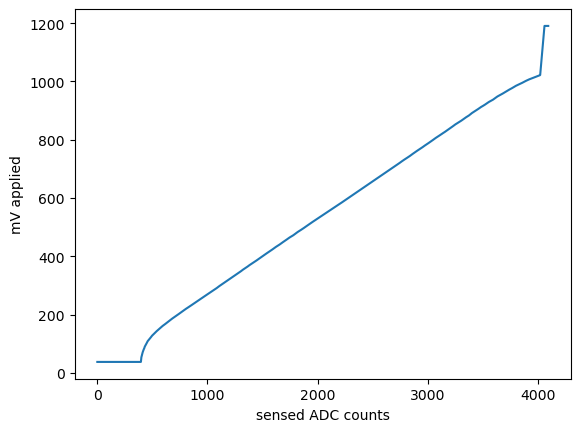

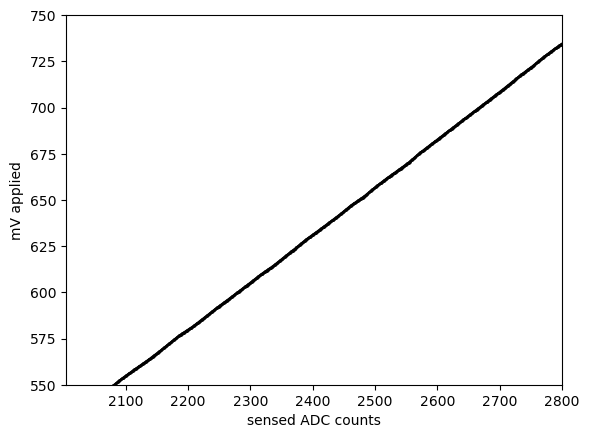

In [3]:
#check an example
datadir = "../../data/calibrations/"
calfiles = glob.glob(datadir+"*.root")
calib_file = calfiles[0]
with uproot.open(calib_file) as f:
	adc_to_mv = f["config_tree"]["adc_to_mv"].array(library="np")
	
adc_to_mv = np.reshape(adc_to_mv, (30,256,4096))



fig, ax = plt.subplots()
ax.plot(np.arange(0, 4096, 1), adc_to_mv[0][0])
ax.set_xlabel("sensed ADC counts")
ax.set_ylabel("mV applied")
plt.show()

fig, ax = plt.subplots()
ax.plot(np.arange(0, 4096, 1), adc_to_mv[0][0], 'ko-', markersize=1)
ax.set_xlim([2004, 2800])
ax.set_ylim([550,750])
ax.set_xlabel("sensed ADC counts")
ax.set_ylabel("mV applied")
plt.show()

In [10]:
#check an example
calib_file = calfiles[0]
with uproot.open(calib_file) as f:
	adc_to_mv = f["config_tree"]["voltage_count_curves"].array(library="np")

print(adc_to_mv.shape)

(30, 256, 256, 2)
